# Домашнее задание по теме "Элементарные методы анализа временных рядов"

## Задание

1. Возьмите из прошлого домашнего задания ряд - стационарный и не стационарный.
2. Приблизьте оба варианта молелями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

## 1. Выбор временного ряда

Для выполнения задания был выбран **Time Series "Monthly Boston Armed Robberies J"**

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### 1.1 Первичный вариант временного ряда

In [4]:
series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
series.head()

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [5]:
series = series['Count']
series.head()

0    41
1    39
2    50
3    40
4    43
Name: Count, dtype: int64

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


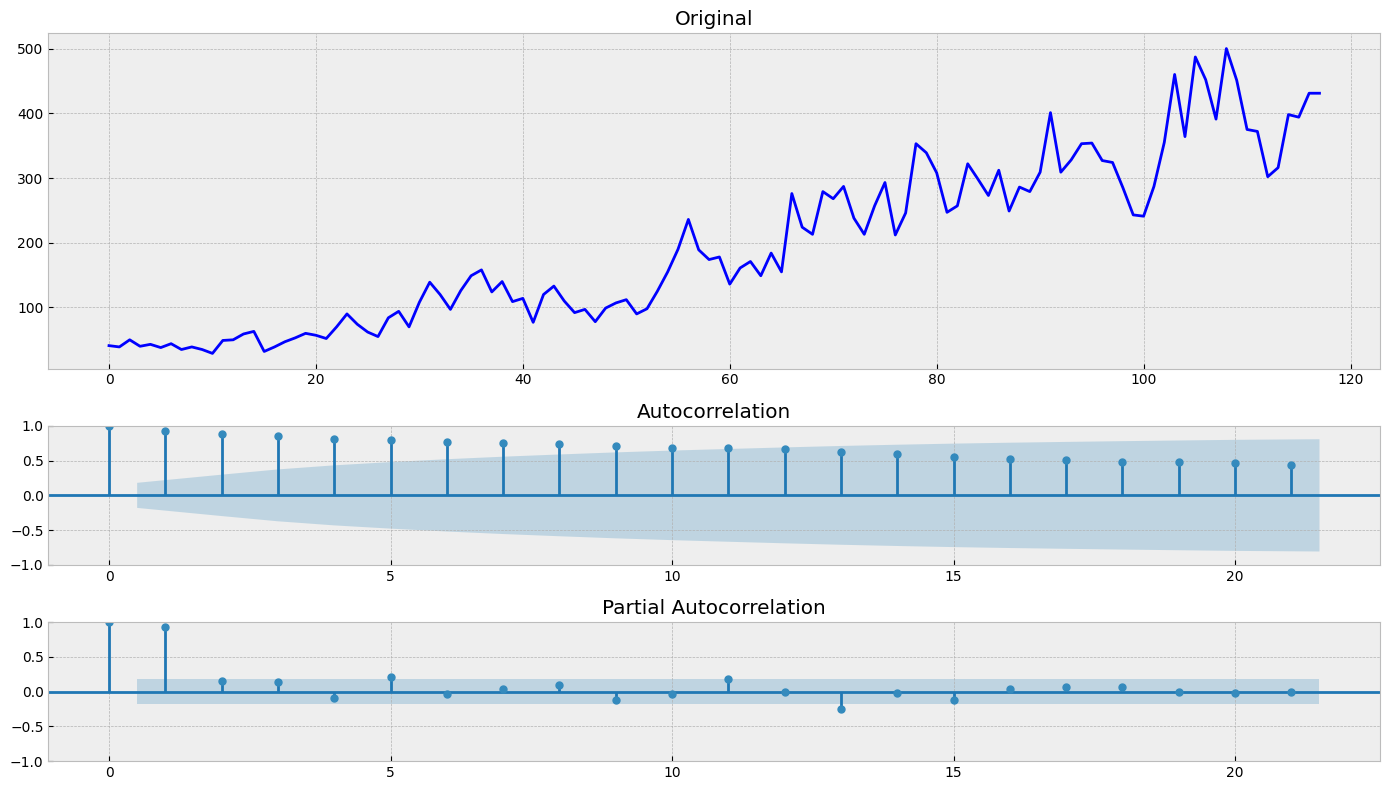

In [6]:
tsplot(series)

Временной ряд "Monthly Boston Armed Robberies J" не является стационарным по следующим признакам:
- Визуально налицо сезонность и тренд.
- Также значения мат ожидания и дисперсии на разных временных отрезках разные.
- Постепенное плавное снижение значения аутокорреляции.
- Тест Дики_Фуллера (p-value > 0.05)

### 1.2 Приведем временной ряд к стационарному виду

Выравниваем дисперсии:

In [7]:
series_stat = boxcox(series, 0)

Избавляемся от тренда:

In [8]:
series_stat = series_stat[1:] - series_stat[:-1]

Избавляемся от сезонности:

In [9]:
series_stat = series_stat[6:] - series_stat[:-6]

Проверяем результат:

Results of Dickey-Fuller Test:
Test Statistic                 -4.546815
p-value                         0.000162
#Lags Used                     12.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


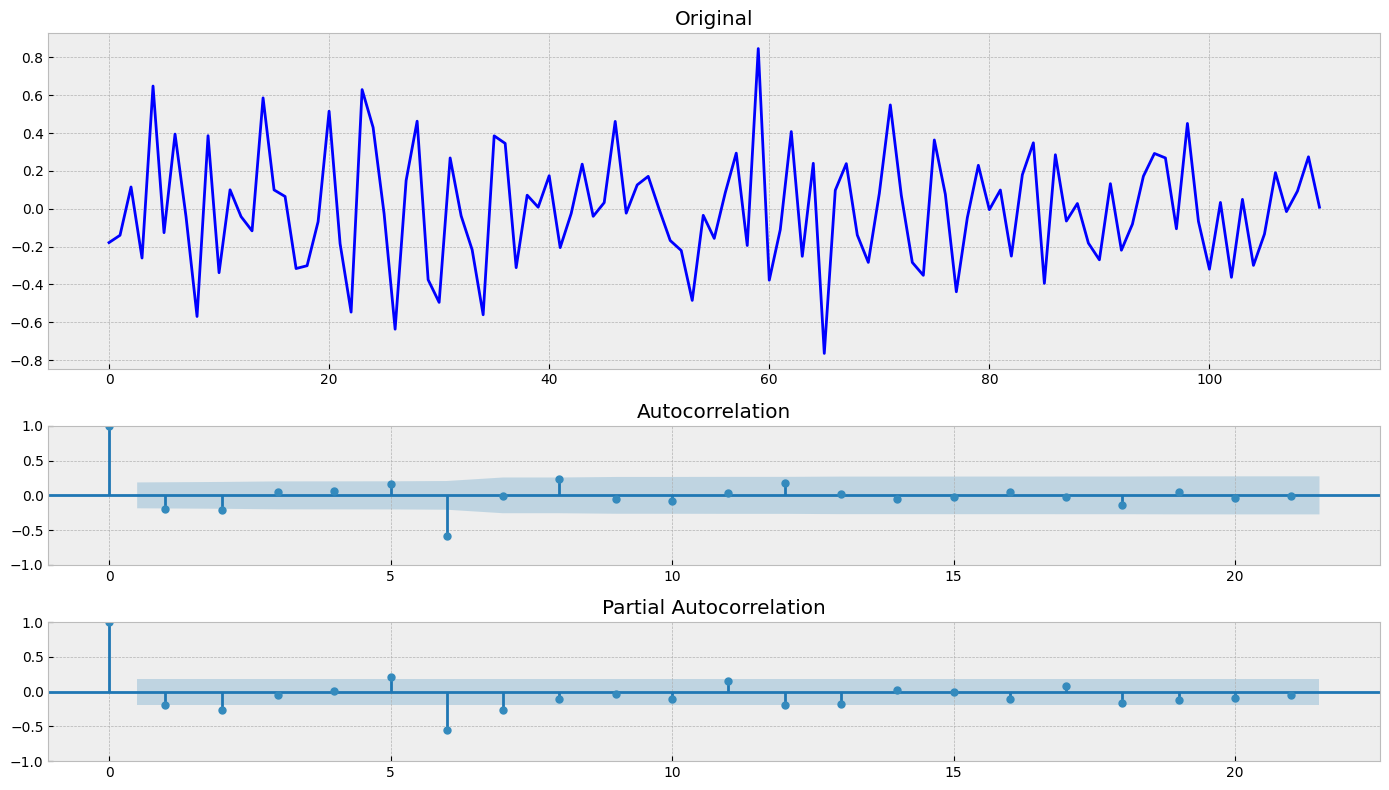

In [10]:
tsplot(series_stat)

- Мы избавились от тренда, разности дисперсии и сезонности.
- Временной ряд стал больше похож на шум.
- При проведении теста Дики-Фуллера значение **p-value** < 0.05.

## 2. Использование моделей из класса MA.

### 2.1 Приближение нестационарного временного ряда series

#### 2.1.1 MA

In [11]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

Попробуем предсказать 20 следующих измерений:

In [12]:
def moving_average_predict(series, n, n_pred):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    ma_series = series.rolling(n).mean()
    for _ in range(n_pred):
        ma_series = ma_series._append(pd.Series([ma_series[-n:].mean()]), ignore_index=True)
    return ma_series

In [13]:
series_predict = moving_average_predict(series, 6, 20)

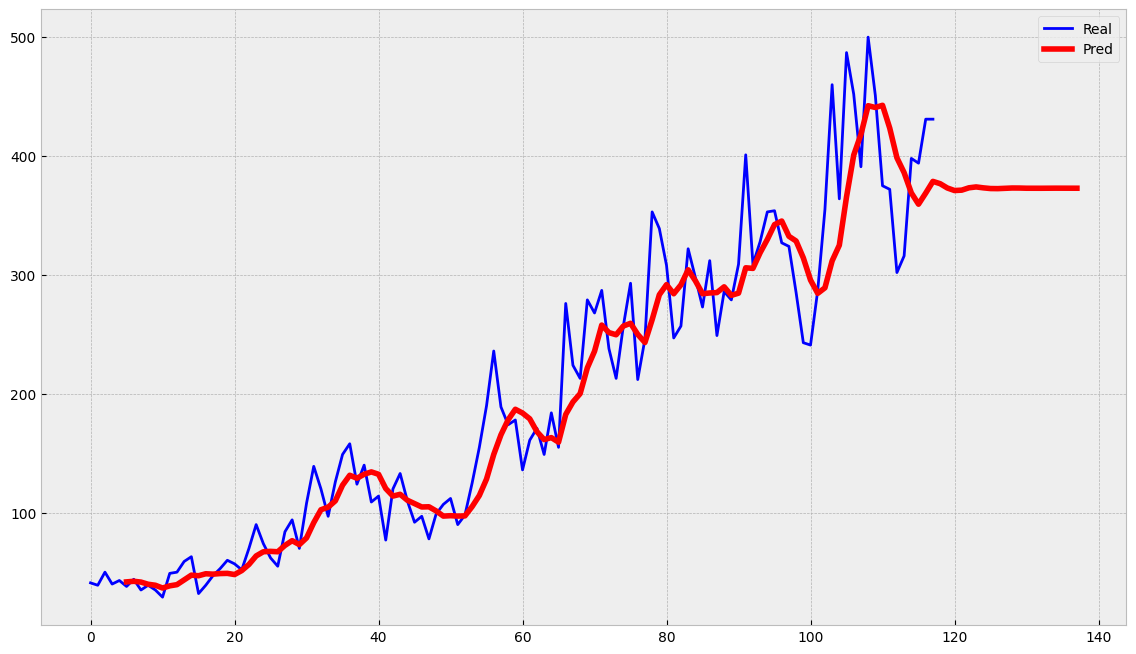

In [14]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth='2', label='Real')
    plt.plot(series_predict, color='red', linewidth='4', label='Pred')
    plt.legend()

#### 2.1.2 WMA

In [15]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

Попробуем, используя WMA, предсказать 20 следующих измерений:

In [16]:
def wma_predict(series, n, weights, n_pred):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma_series = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    for _ in range(n_pred):
        wma_series = wma_series._append(pd.Series([(wma_series[-n:] * (weights / weights.sum())).sum()]), ignore_index=True)
    return wma_series

In [17]:
wma_pred = wma_predict(series, 7, [1,1,2,3,5,8,13], 20)

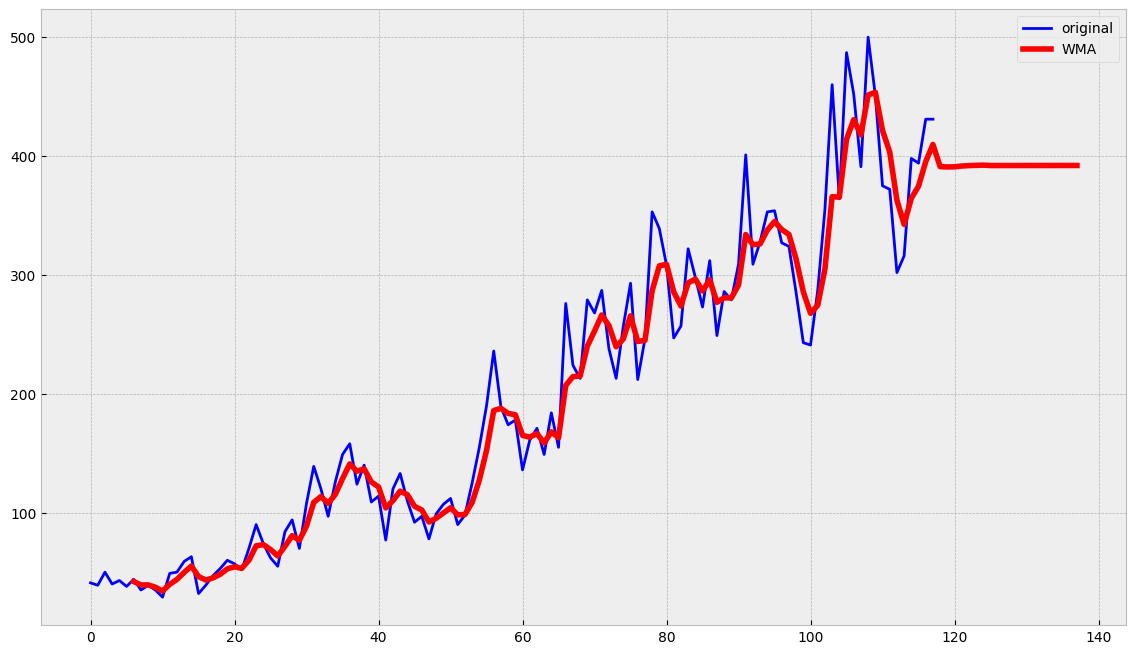

In [18]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth='2', label='original')
    plt.plot(wma_pred, color='red', linewidth='4', label='WMA')        
    plt.legend()

#### 2.1.3 EMA

In [19]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

Попробуем, используя EMA, предсказать 20 следующих измерений:

In [20]:
def ema_predict(series, alpha, n_pred):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    predict = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]
    for _ in range(n_pred):
        res = alpha * predict[-1] + (1 - alpha) * result[-1]
        result.append(res)
    return(pd.Series(result))

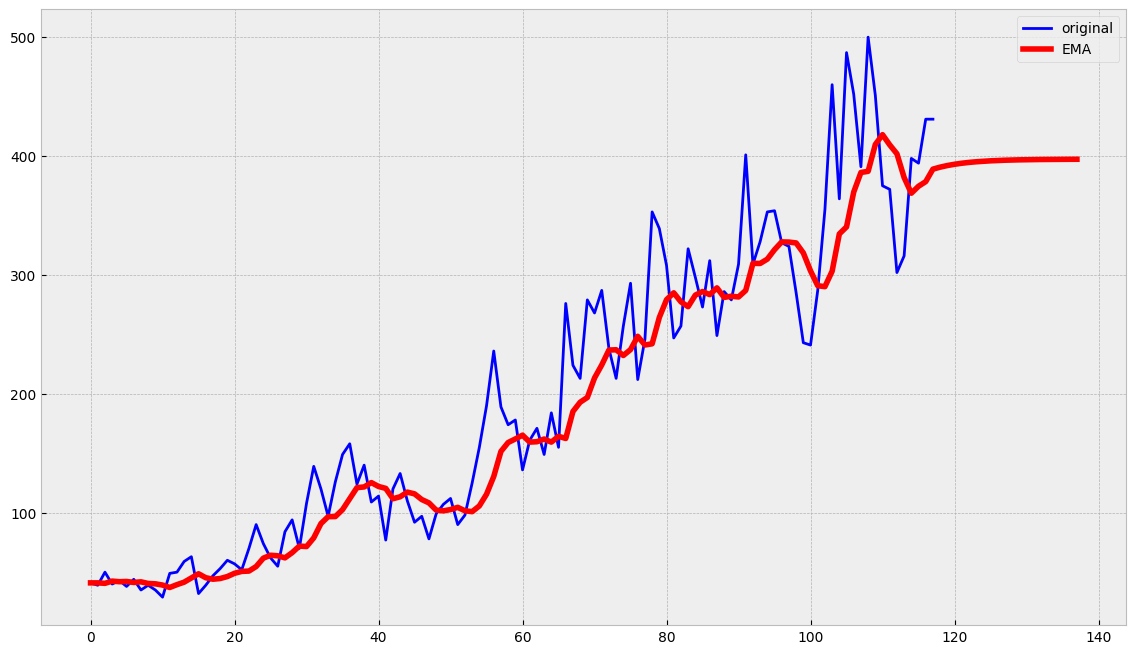

In [21]:
ema_pred = ema_predict(series, 0.2, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ema_pred, color='red', linewidth='4', label='EMA')        
    plt.legend()

#### 2.1.4 DEMA

In [22]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

Попробуем, используя DEMA, предсказать 20 следующих измерений:

In [23]:
def dema_predict(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    preds = result
    for _ in range(n_preds):
        value = preds[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        preds.append(level+trend)
    return pd.Series(preds)

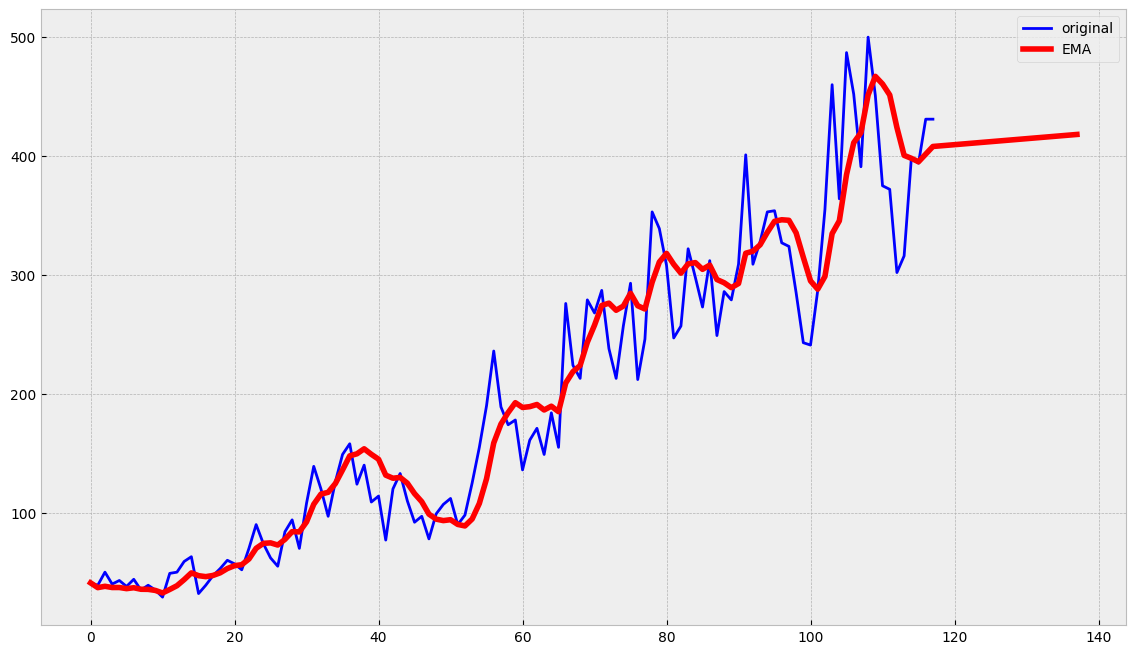

In [24]:
dema_pred = dema_predict(series, 0.2, 0.2, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(dema_pred, color='red', linewidth='4', label='EMA')        
    plt.legend()

#### 2.1.5 TEMA

Попробуем, используя TEMA, предсказать 20 следующих измерений:

In [70]:
model = sm.tsa.ExponentialSmoothing(
    series, trend='add', seasonal='add', seasonal_periods=14
)
tes_model = model.fit(
    smoothing_level=0, smoothing_trend=1, smoothing_seasonal=1
)
# tes_series = tes_model.fittedvalues
tes_pred = pd.concat([tes_model.fittedvalues, tes_model.forecast(20)])

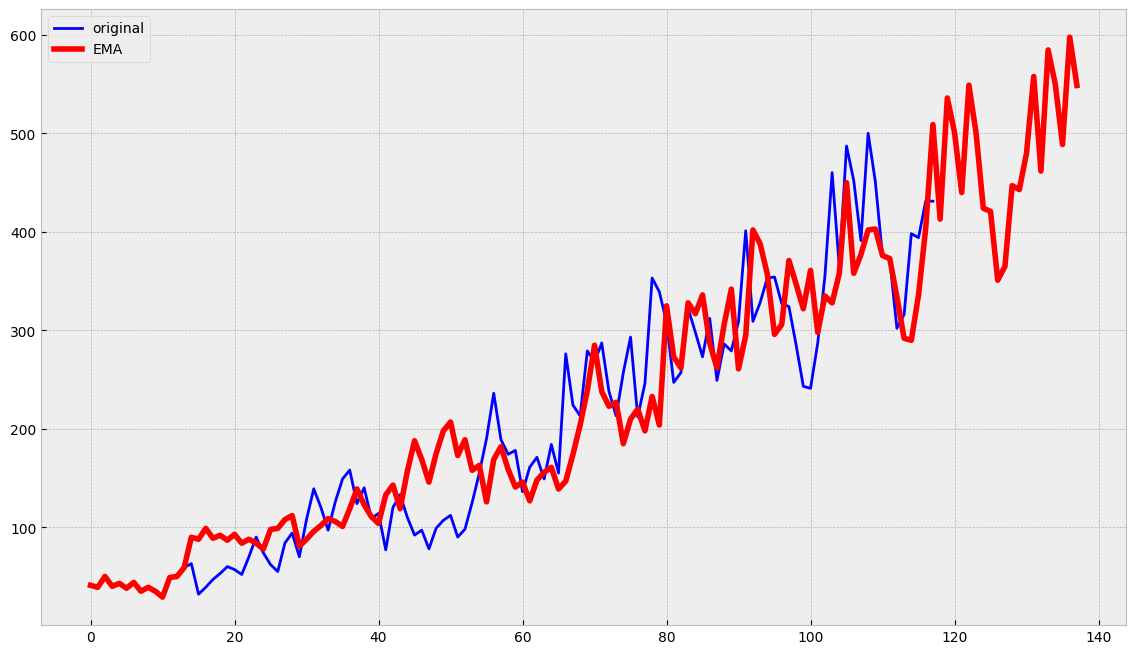

In [71]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(tes_pred, color='red', linewidth='4', label='EMA')        
    plt.legend()

### 2.2 Приближение стационарного временного ряда series_stat

#### 2.2.1 MA

Попробуем, используя MA, предсказать 20 следующих измерений:

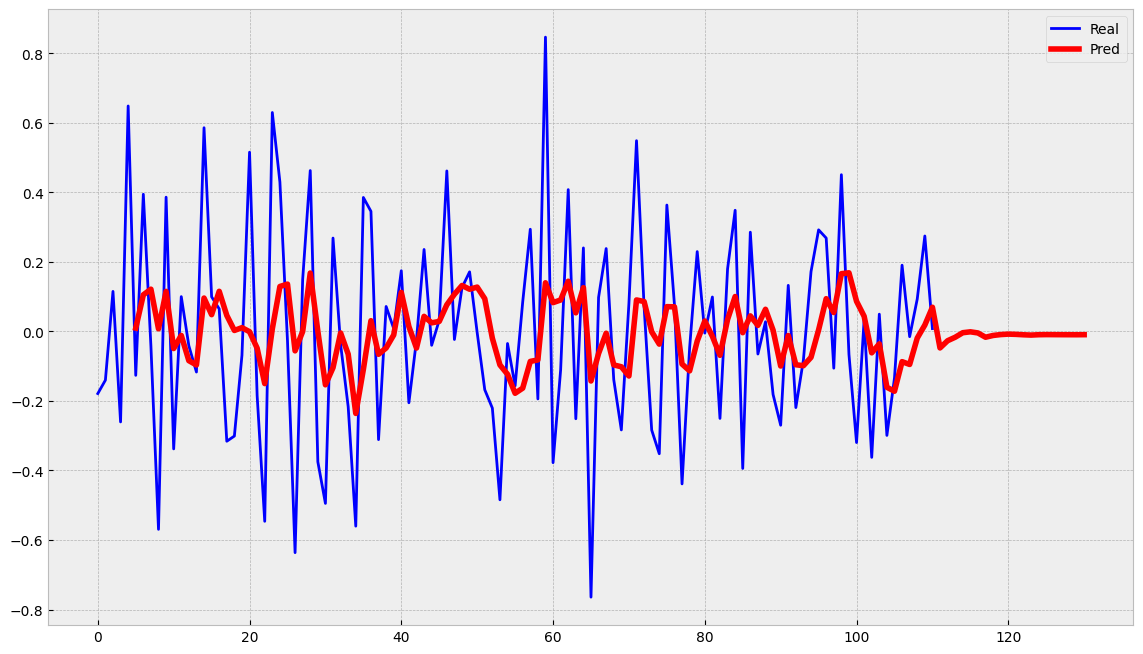

In [27]:
series_predict = moving_average_predict(series_stat, 6, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue', linewidth='2', label='Real')
    plt.plot(series_predict, color='red', linewidth='4', label='Pred')
    plt.legend()

#### 2.2.2 WMA

Попробуем, используя WMA, предсказать 20 следующих измерений:

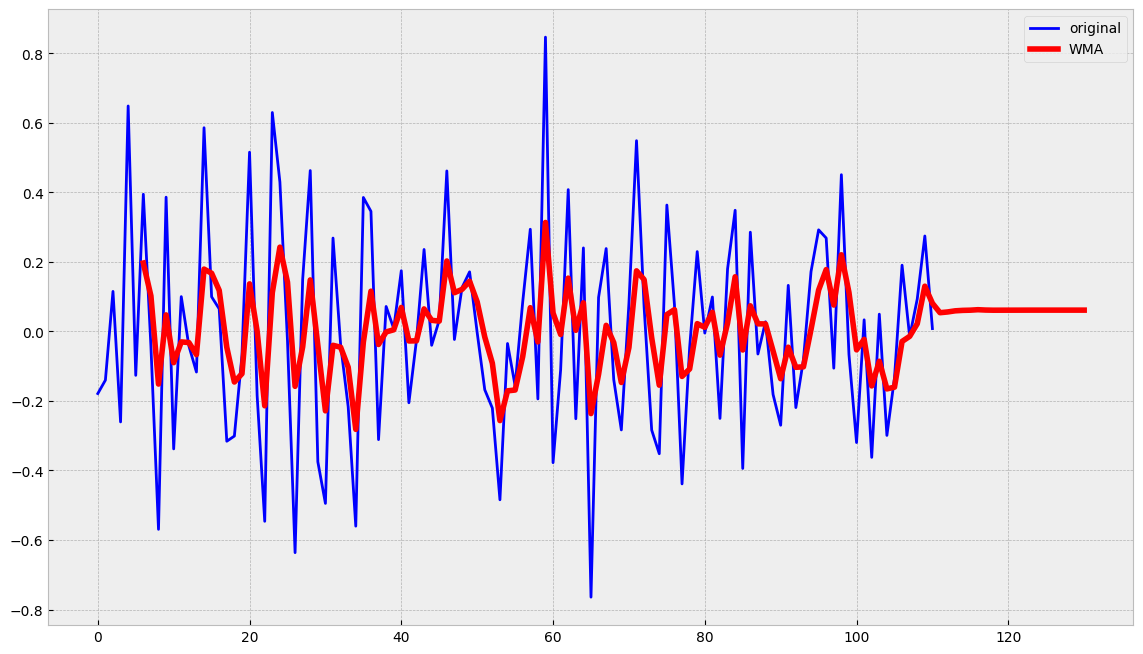

In [28]:
wma_pred = wma_predict(series_stat, 7, [1,1,2,3,5,8,13], 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue', linewidth='2', label='original')
    plt.plot(wma_pred, color='red', linewidth='4', label='WMA')        
    plt.legend()

#### 2.2.3 EMA

Попробуем, используя EMA, предсказать 20 следующих измерений:

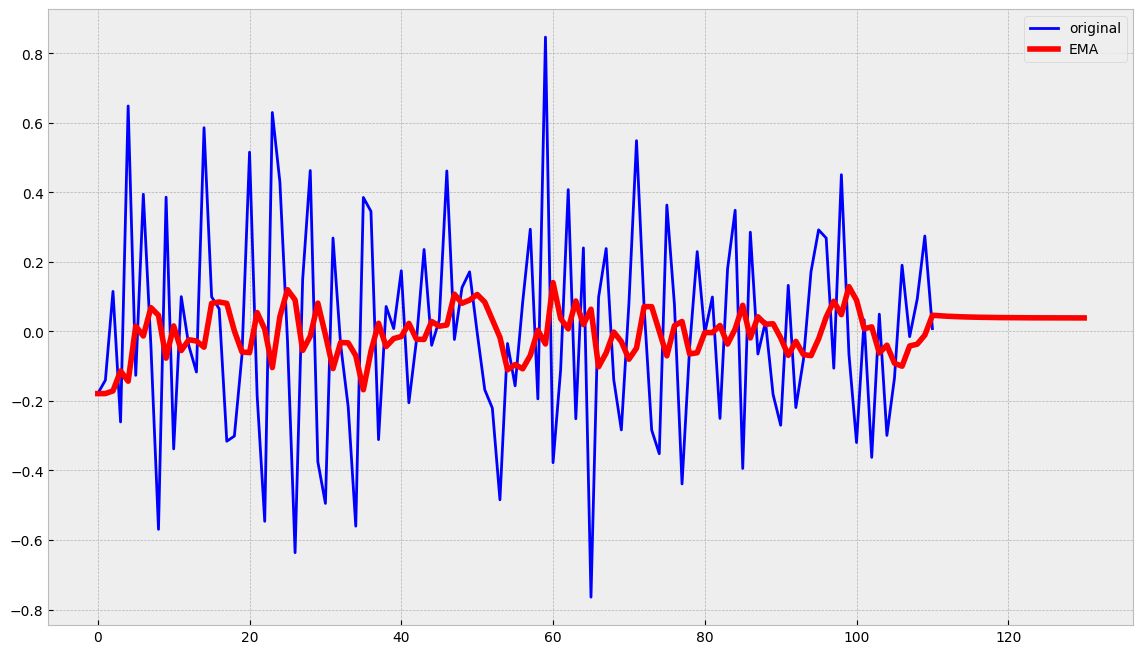

In [29]:
ema_pred = ema_predict(series_stat, 0.2, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue',label='original')
    plt.plot(ema_pred, color='red', linewidth='4', label='EMA')        
    plt.legend()

#### 2.2.4 DEMA

Попробуем, используя DEMA, предсказать 20 следующих измерений:

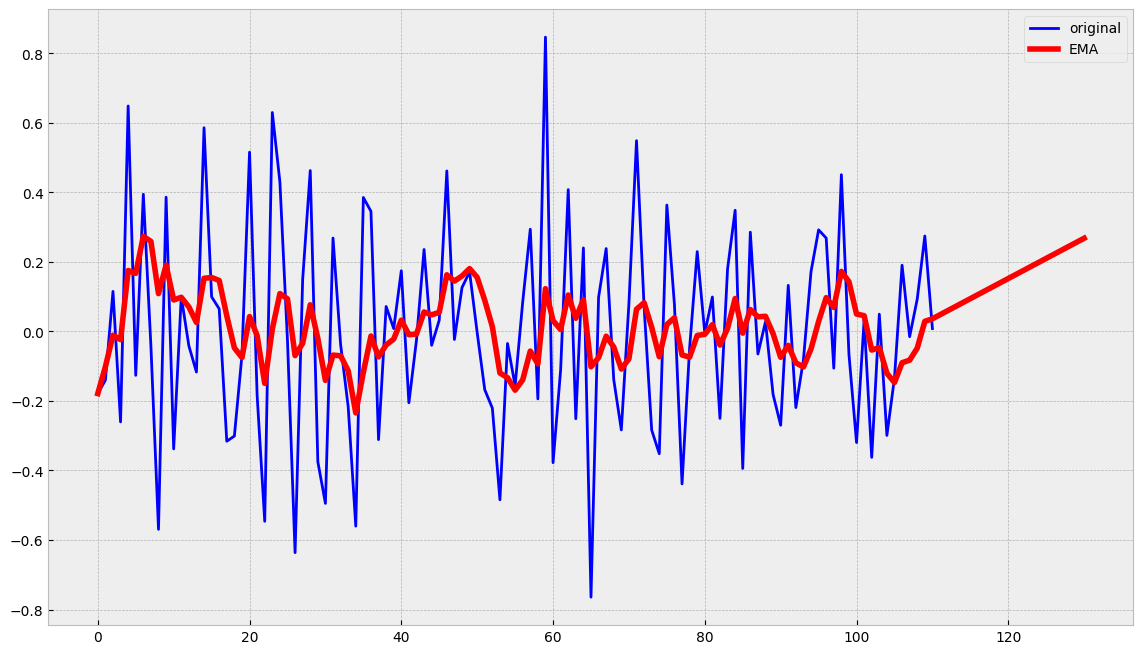

In [30]:
dema_pred = dema_predict(series_stat, 0.2, 0.2, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue',label='original')
    plt.plot(dema_pred, color='red', linewidth='4', label='EMA')        
    plt.legend()

#### 2.2.5 TEMA

Попробуем, используя TEMA, предсказать 20 следующих измерений:

In [87]:
model = sm.tsa.ExponentialSmoothing(
    pd.Series(series_stat), trend='add', seasonal='add', seasonal_periods=14
)
tes_model = model.fit(
    smoothing_level=0.0, smoothing_trend=0.0, smoothing_seasonal=0.0
)
# tes_series = tes_model.fittedvalues
tes_pred = pd.concat([tes_model.fittedvalues, tes_model.forecast(20)])

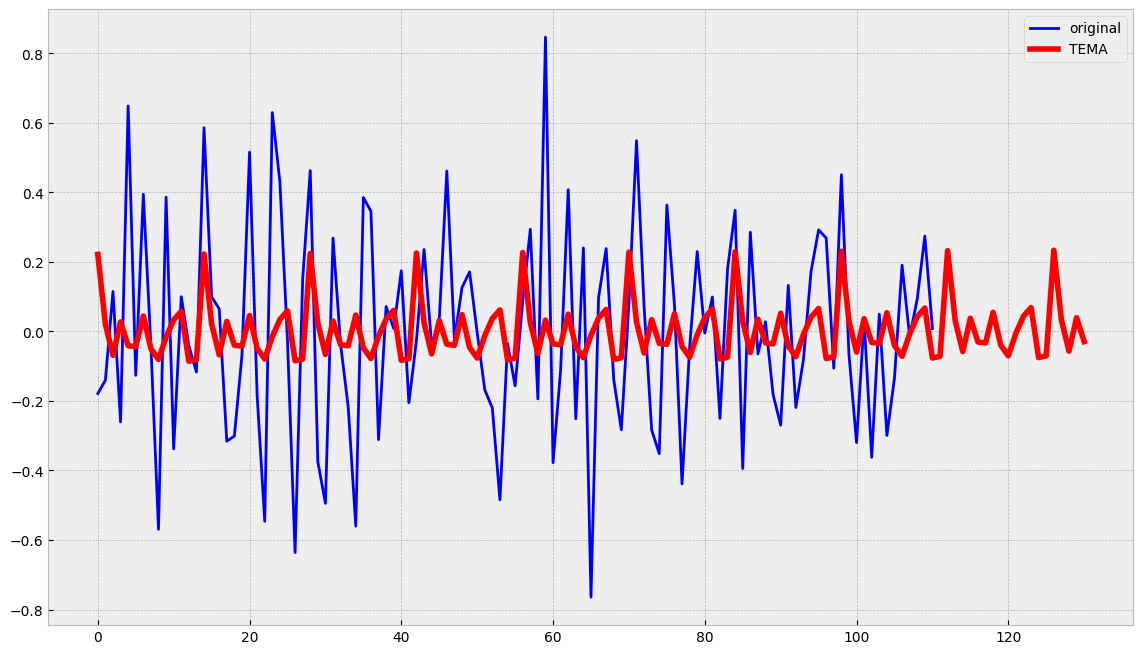

In [88]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue',label='original')
    plt.plot(tes_pred, color='red', linewidth='4', label='TEMA')        
    plt.legend()

## 3. Подбор параметров TEMA

In [60]:
import itertools

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

### 3.1  Временной ряд series

In [37]:
series.shape

(118,)

In [49]:
train, test, val = series[:71], series[71:101], series[101:]

In [50]:
def mse(X):
    alpha, beta, gamma = X
    model = sm.tsa.ExponentialSmoothing(
        train,
        trend='add', seasonal='add',
        seasonal_periods=12)
    tes_model = model.fit(
        smoothing_level=alpha,
        smoothing_trend=beta,
        smoothing_seasonal=gamma)
    prediction = tes_model.forecast(30)
    error = mean_squared_error(prediction, test)
    return error

In [51]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [52]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3989.8351689255474
        x: [ 0.000e+00  1.000e+00  1.000e+00]
      nit: 1
      jac: [ 3.318e+05 -0.000e+00 -1.645e+05]
     nfev: 8
     njev: 2
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [68]:
model = sm.tsa.ExponentialSmoothing(
        train,
        trend='add', seasonal='add',
        seasonal_periods=12)

tes_model = model.fit(
        smoothing_level=0.0,
        smoothing_trend=1.0,
        smoothing_seasonal=1.0)

tes_series = pd.concat([tes_model.fittedvalues, tes_model.forecast(30)])


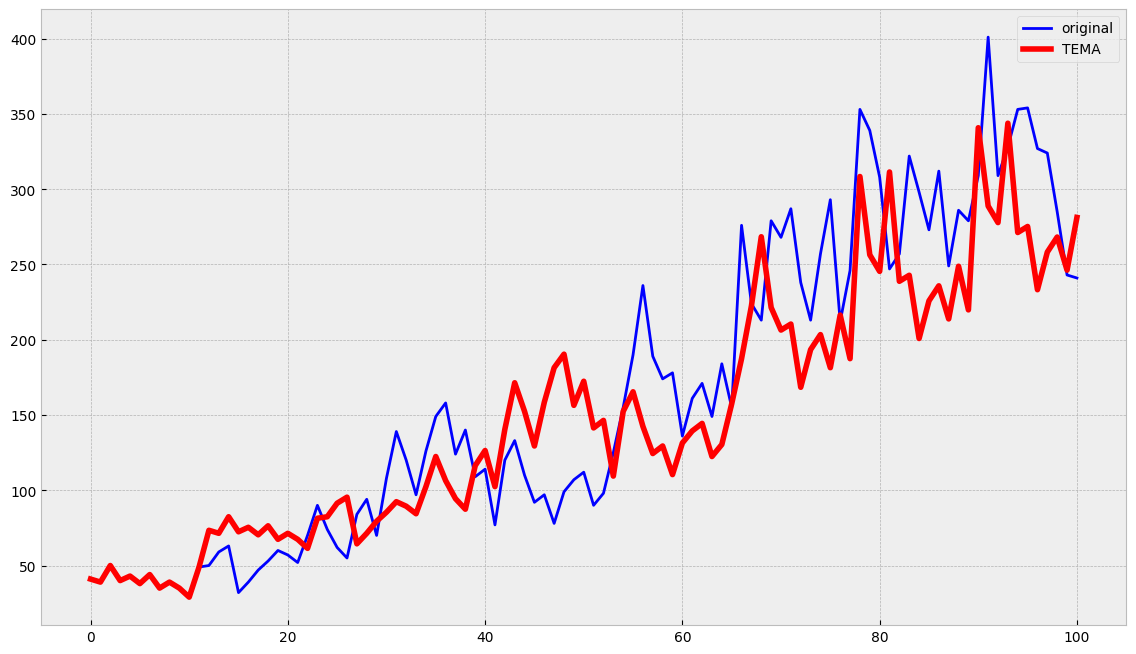

In [69]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series[:101], color='blue',label='original')
    plt.plot(tes_series, color='red', linewidth='4', label='TEMA')        
    plt.legend()

### 3.2  Временной ряд series_stat

In [81]:
series_stat = pd.Series(series_stat)
series_stat.shape

(111,)

In [82]:
train, test, val = series_stat[:71], series_stat[71:101], series_stat[101:]

In [83]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [84]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.051830961064638505
        x: [ 0.000e+00  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 1.325e+01  8.890e+00  1.288e+01]
     nfev: 4
     njev: 1
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [85]:
model = sm.tsa.ExponentialSmoothing(
        train,
        trend='add', seasonal='add',
        seasonal_periods=12)

tes_model = model.fit(
        smoothing_level=0.0,
        smoothing_trend=0.0,
        smoothing_seasonal=0.0)

tes_series = pd.concat([tes_model.fittedvalues, tes_model.forecast(30)])

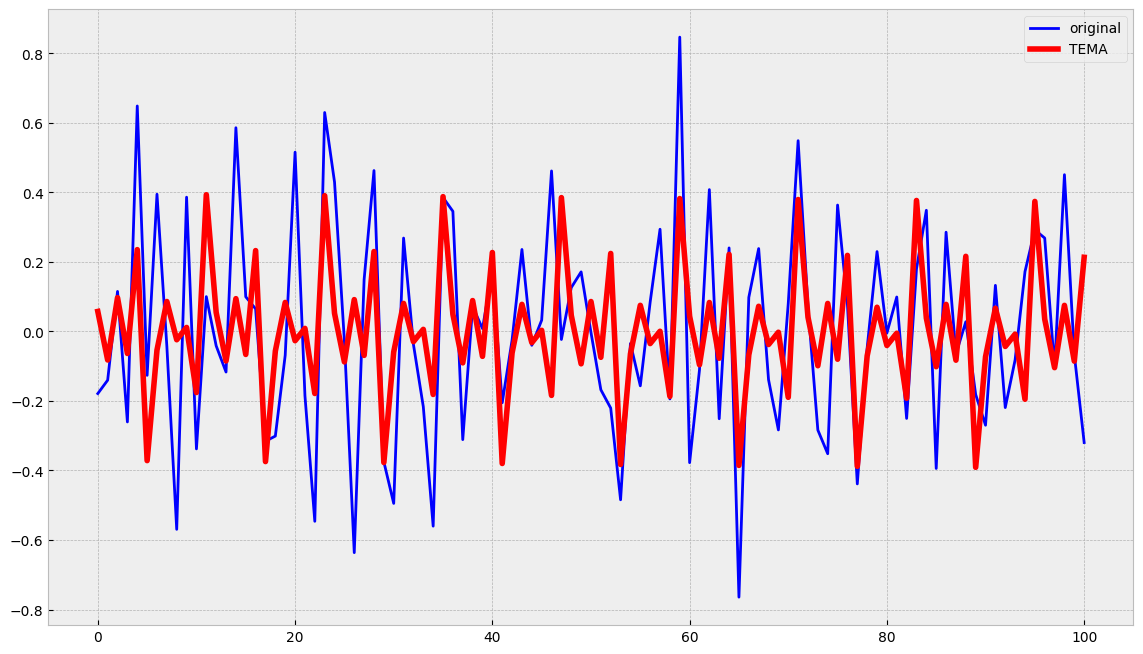

In [86]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat[:101], color='blue',label='original')
    plt.plot(tes_series, color='red', linewidth='4', label='TEMA')        
    plt.legend()

## Выводы:

- В плане сглаживания временных рядов все методы показали примерно одинаковые результаты
- Лучшие результаты прогноза значений временного ряда показал метод Хольта-Винтерса